In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
!pip install dtaidistance
from dtaidistance import dtw
from scipy.stats import pearsonr
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.9 MB/s eta 0:00:00


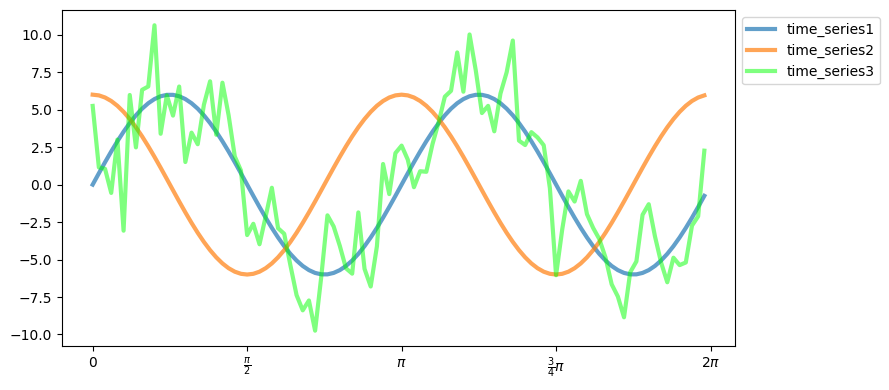

Distance between time_series1, time_series2 60.0
Distance between time_series1, time_series3 23.309529496621625
Distance between time_series2, time_series3 63.92627393614129


In [2]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# define frequencies, amplitudes, and sampling rate and time array
f1 =  2  # Frequency 1 in Hz
f2 = 10  # Frequency 2 in Hz
A1 = 6   # Amplitude 1
A2 = 2   # Amplitude 2
Fs = 100 # Sampling rate
t  = np.arange(0,1,1/Fs)

# calculate prime signals
time_series1 = A1 * np.sin(2 * np.pi * f1 * t)
time_series2 = A1 * np.cos(2 * np.pi * f1 * t)
A_cos = A2 * np.cos(2 * np.pi * f2 * t)
A_signal = time_series1 + A_cos


# add some noise
np.random.seed(1)
A_Noise = 2
Noise = np.random.randn(len(t)) * A_Noise
time_series3 = A_signal + Noise

# plots
fig=plt.figure(3, figsize=(9,4))
plt.clf()
plt.plot(t, time_series1, label="time_series1", lw=3, alpha=0.7)
plt.plot(t, time_series2, label="time_series2", lw=3, alpha=0.7)
plt.plot(t, time_series3, lw=3, c="lime",
         label="time_series3", alpha=0.5)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.xticks([0, 0.25, 0.5, 0.75, 1],
           ["0", r"$\frac{\pi}{2}$", r"$\pi$",
            r"$\frac{3}{4}\pi$", r"$2\pi$"])
plt.tight_layout()
plt.show()

print(f"Distance between time_series1, time_series2 {euclidean_distance(time_series1, time_series2)}")
print(f"Distance between time_series1, time_series3 {euclidean_distance(time_series1, time_series3)}")
print(f"Distance between time_series2, time_series3 {euclidean_distance(time_series3, time_series2)}")

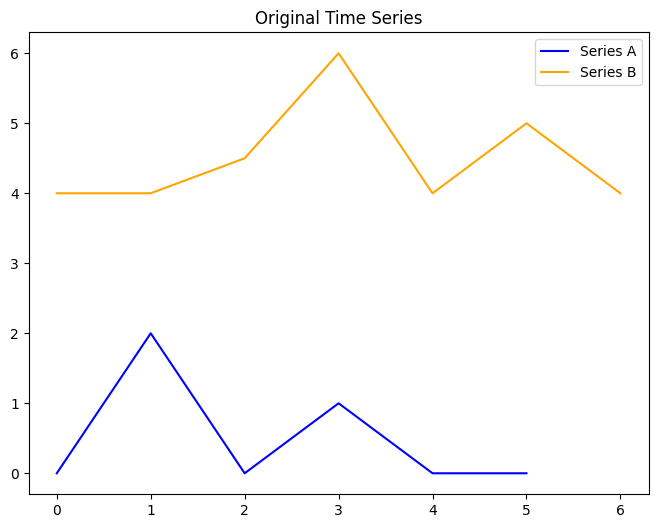

In [3]:
import numpy as np
import scipy.spatial
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline

X = np.array([0,2,0,1,0,0])
Y = np.array([0,0,0.5,2,0,1,0])
N = len(X)
M = len(Y)

shift_value = 4
Y_shifted = Y + shift_value

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plotting the time series
ax1.plot(X, label='Series A', color='blue')
ax1.plot(Y_shifted, label='Series B', color='orange')

# Setting the title and legend
ax1.set_title('Original Time Series')
ax1.legend()

plt.show()


In [4]:
distance, paths = dtw.warping_paths(X, Y, use_c=False)
best_path = dtw.best_path(paths)
similarity_score = distance / len(best_path)

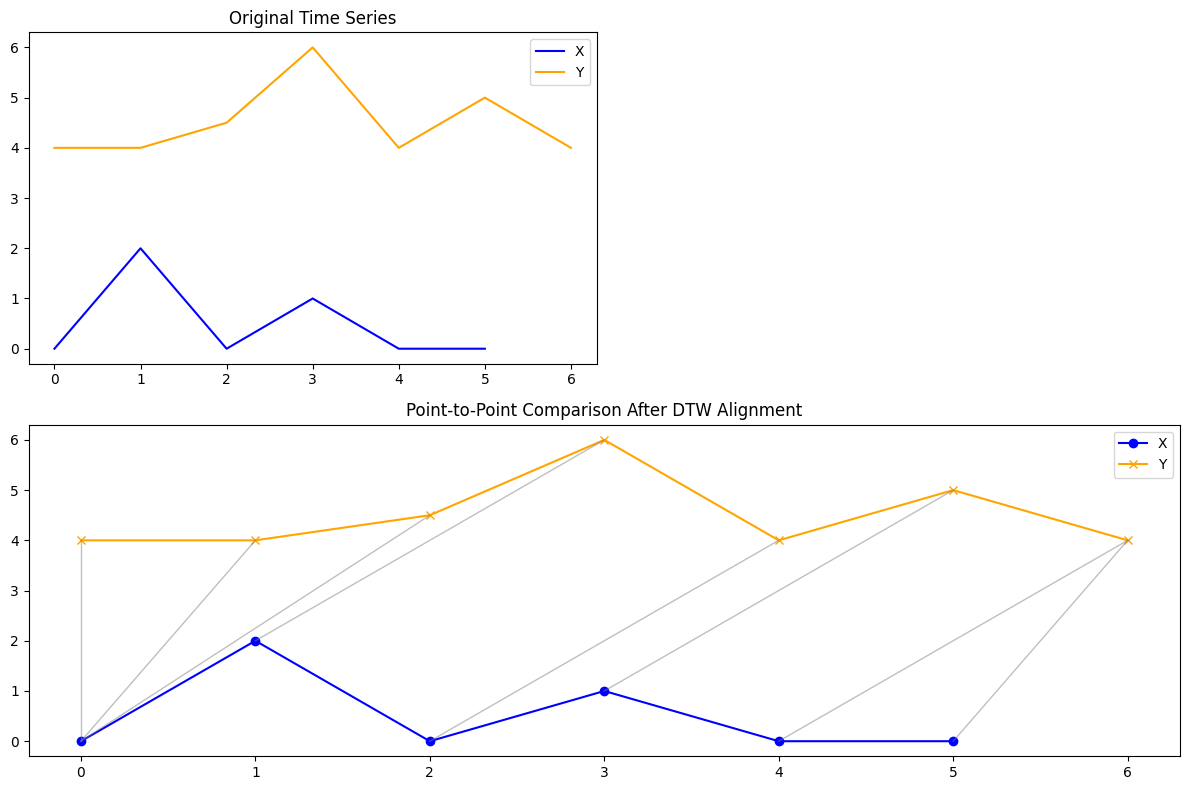

In [11]:
plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(X, label='X', color='blue')
ax1.plot(Y_shifted, label='Y', color='orange')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
# In this example, only the path is plotted, not the entire cost matrix.

# ax2 = plt.subplot2grid((2, 2), (0, 1))
# ax2.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1], 'green', marker='o', linestyle='-')
# ax2.set_title('Shortest Path (Best Path)')
# ax2.set_xlabel('X')
# ax2.set_ylabel('Y')
# ax2.grid(True)

# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(X, label='X', color='blue', marker='o')
ax3.plot(Y_shifted, label='Y', color='orange', marker='x')
for a, b in best_path:
    ax3.plot([a, b], [X[a], Y_shifted[b]], color='grey', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

In [25]:
def compute_cost_matrix(X, Y, metric='euclidean'):
    X, Y = np.atleast_2d(X, Y)
    C = scipy.spatial.distance.cdist(X.T, Y.T, metric=metric)
    return C

C = compute_cost_matrix(X, Y, metric='euclidean')
print('Cost matrix C =', C[::-1], sep='\n')

Cost matrix C =
[[0.  0.  0.5 2.  0.  1.  0. ]
 [0.  0.  0.5 2.  0.  1.  0. ]
 [1.  1.  0.5 1.  1.  0.  1. ]
 [0.  0.  0.5 2.  0.  1.  0. ]
 [2.  2.  1.5 0.  2.  1.  2. ]
 [0.  0.  0.5 2.  0.  1.  0. ]]


In [26]:
@jit(nopython=True)
def compute_accumulated_cost_matrix(C):
    N = C.shape[0]
    M = C.shape[1]
    D = np.zeros((N, M))
    D[0, 0] = C[0, 0]
    for n in range(1, N):
        D[n, 0] = D[n-1, 0] + C[n, 0]
    for m in range(1, M):
        D[0, m] = D[0, m-1] + C[0, m]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

D =  compute_accumulated_cost_matrix(C)
print('Accumulated cost matrix D =', D[::-1], sep='\n')
print('DTW distance DTW(X, Y) =', D[-1, -1])

Accumulated cost matrix D =
[[3.  3.  3.5 5.  1.5 2.5 0.5]
 [3.  3.  3.  4.5 1.5 1.5 0.5]
 [3.  3.  2.5 3.  1.5 0.5 1.5]
 [2.  2.  2.  2.5 0.5 1.5 1.5]
 [2.  2.  1.5 0.5 2.5 3.5 5.5]
 [0.  0.  0.5 2.5 2.5 3.5 3.5]]
DTW distance DTW(X, Y) = 0.5


In [27]:
@jit(nopython=True)
def compute_optimal_warping_path(D):
    N = D.shape[0]
    M = D.shape[1]
    n = N - 1
    m = M - 1
    P = [(n, m)]
    while n > 0 or m > 0:
        if n == 0:
            cell = (0, m - 1)
        elif m == 0:
            cell = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                cell = (n-1, m-1)
            elif val == D[n-1, m]:
                cell = (n-1, m)
            else:
                cell = (n, m-1)
        P.append(cell)
        (n, m) = cell
    P.reverse()
    return np.array(P)

P = compute_optimal_warping_path(D)
print('Optimal warping path P =', P.tolist())

Optimal warping path P = [[0, 0], [0, 1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 6]]


In [28]:
c_P = sum(C[n, m] for (n, m) in P)
print('Total cost of optimal warping path:', c_P)
print('DTW distance DTW(X, Y) =', D[-1, -1])

Total cost of optimal warping path: 0.5
DTW distance DTW(X, Y) = 0.5


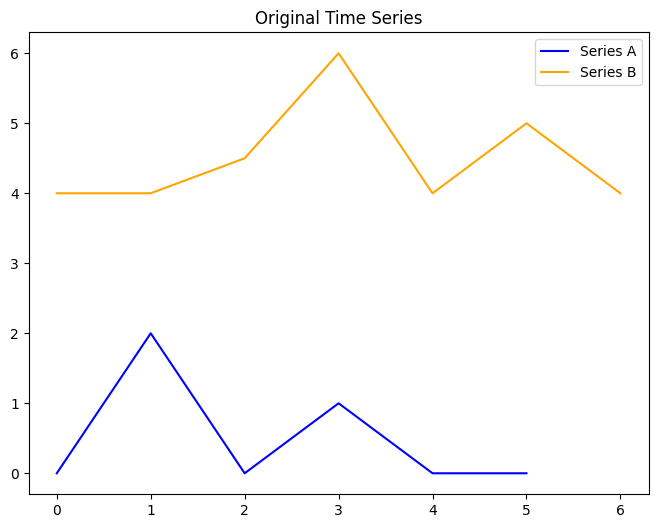

Cost matrix C =
[[0.  0.  0.5 2.  0.  1.  0. ]
 [0.  0.  0.5 2.  0.  1.  0. ]
 [1.  1.  0.5 1.  1.  0.  1. ]
 [0.  0.  0.5 2.  0.  1.  0. ]
 [2.  2.  1.5 0.  2.  1.  2. ]
 [0.  0.  0.5 2.  0.  1.  0. ]]
Accumulated cost matrix D =
[[3.  3.  3.5 5.  1.5 2.5 0.5]
 [3.  3.  3.  4.5 1.5 1.5 0.5]
 [3.  3.  2.5 3.  1.5 0.5 1.5]
 [2.  2.  2.  2.5 0.5 1.5 1.5]
 [2.  2.  1.5 0.5 2.5 3.5 5.5]
 [0.  0.  0.5 2.5 2.5 3.5 3.5]]
DTW distance DTW(X, Y) = 0.5


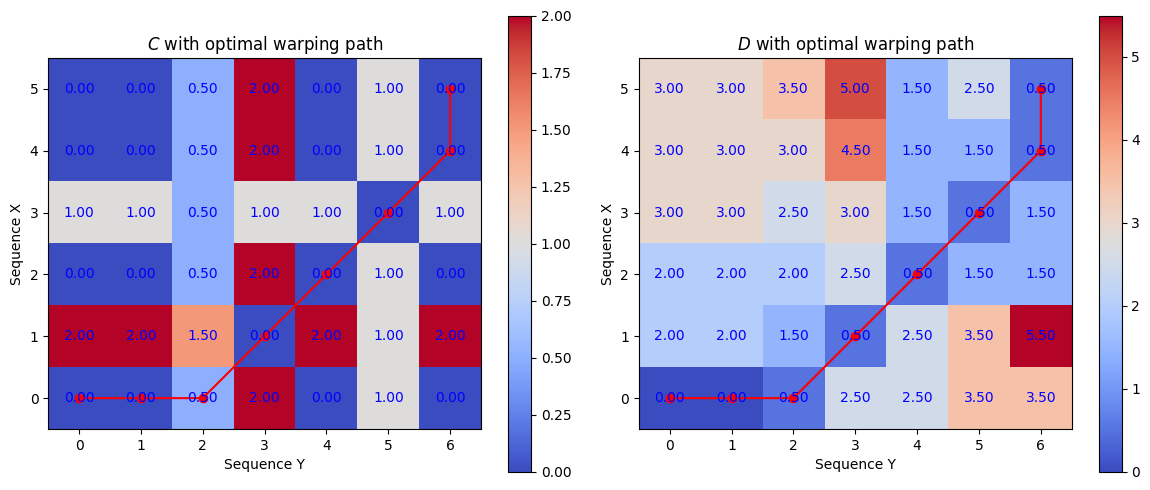

In [31]:
import numpy as np
import scipy.spatial
from numba import jit
import matplotlib.pyplot as plt

X = np.array([0, 2, 0, 1, 0, 0])
Y = np.array([0, 0, 0.5, 2, 0, 1, 0])
N = len(X)
M = len(Y)

shift_value = 4
Y_shifted = Y + shift_value

#  Plot original time series
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(X, label='Series A', color='blue')
ax1.plot(Y_shifted, label='Series B', color='orange')
ax1.set_title('Original Time Series')
ax1.legend()
plt.show()

#  Functions to compute cost matrix and accumulated cost matrix
def compute_cost_matrix(X, Y, metric='euclidean'):
    X, Y = np.atleast_2d(X, Y)
    C = scipy.spatial.distance.cdist(X.T, Y.T, metric=metric)
    return C

@jit(nopython=True)
def compute_accumulated_cost_matrix(C):
    N = C.shape[0]
    M = C.shape[1]
    D = np.zeros((N, M))
    D[0, 0] = C[0, 0]
    for n in range(1, N):
        D[n, 0] = D[n-1, 0] + C[n, 0]
    for m in range(1, M):
        D[0, m] = D[0, m-1] + C[0, m]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

#  Compute matrices
C = compute_cost_matrix(X, Y, metric='euclidean')
print('Cost matrix C =', C[::-1], sep='\n')

D = compute_accumulated_cost_matrix(C)
print('Accumulated cost matrix D =', D[::-1], sep='\n')
print('DTW distance DTW(X, Y) =', D[-1, -1])

#  Now find the optimal warping path
def compute_optimal_warping_path(D):
    n, m = np.array(D.shape) - 1
    path = [(n, m)]
    while (n > 0) or (m > 0):
        if n == 0:
            m = m - 1
        elif m == 0:
            n = n - 1
        else:
            idx = np.argmin([D[n-1, m-1], D[n-1, m], D[n, m-1]])
            if idx == 0:
                n, m = n-1, m-1
            elif idx == 1:
                n = n-1
            else:  # idx == 2
                m = m-1
        path.append((n, m))
    path.reverse()
    return np.array(path)

P = compute_optimal_warping_path(D)

#  Now plot heatmaps and warping path with numbers
plt.figure(figsize=(12, 5))

#  First subplot: Cost matrix C
plt.subplot(1, 2, 1)
plt.imshow(C, cmap="coolwarm", origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='red')
plt.clim([0, np.max(C)])
plt.colorbar()
plt.title('$C$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

# Add numbers to heatmap
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        plt.text(j, i, f'{C[i, j]:.2f}', ha='center', va='center', color='blue')

#  Second subplot: Accumulated cost matrix D
plt.subplot(1, 2, 2)
plt.imshow(D, cmap='coolwarm', origin='lower', aspect='equal')
plt.plot(P[:, 1], P[:, 0], marker='o', color='red')
plt.clim([0, np.max(D)])
plt.colorbar()
plt.title('$D$ with optimal warping path')
plt.xlabel('Sequence Y')
plt.ylabel('Sequence X')

# Add numbers to heatmap
for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        plt.text(j, i, f'{D[i, j]:.2f}', ha='center', va='center', color='blue')

plt.tight_layout()
plt.show()


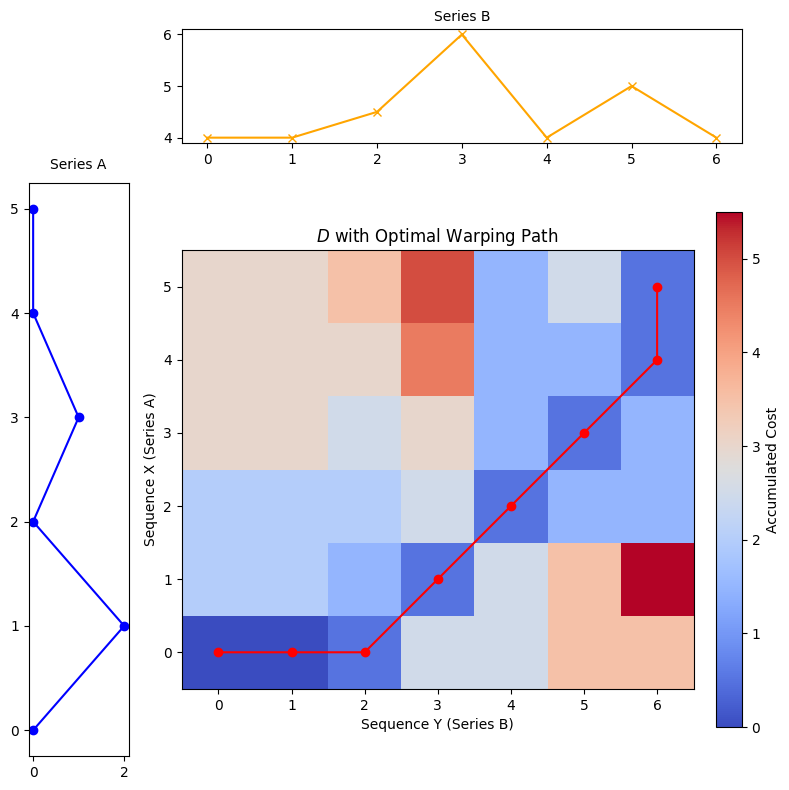

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw

# Compute DTW distance and best path if needed
distance, paths = dtw.warping_paths(X, Y, use_c=False)
P = np.array(dtw.best_path(paths))  # Best warping path

# Create figure
fig = plt.figure(figsize=(8, 8))

# ========== Top: Series B ========== #
ax_seriesB = plt.subplot2grid((5, 5), (0, 1), rowspan=1, colspan=4)

# Plot Series B on top
ax_seriesB.plot(np.arange(len(Y)), Y_shifted, color='orange', marker='x')
# ax_seriesB.axis('off')
ax_seriesB.set_title('Series B', fontsize=10)

# ========== Left Side: Series A ========== #
ax_seriesA = plt.subplot2grid((5, 5), (1, 0), rowspan=4, colspan=1, sharey=None)

# Plot Series A on left
ax_seriesA.plot(X, np.arange(len(X)), color='blue', marker='o')
# ax_seriesA.invert_xaxis()
# ax_seriesA.invert_yaxis()
# ax_seriesA.axis('off')
ax_seriesA.set_title('Series A', fontsize=10, pad=10)

# ========== Main Heatmap ========== #
ax_heatmap = plt.subplot2grid((5, 5), (1, 1), rowspan=4, colspan=4)

# Plot the accumulated cost matrix D
heatmap = ax_heatmap.imshow(D, cmap='coolwarm', origin='lower', aspect='equal')
ax_heatmap.plot(P[:, 1], P[:, 0], marker='o', color='red')  # Warping path

# Colorbar
cbar = plt.colorbar(heatmap, ax=ax_heatmap, fraction=0.046, pad=0.04)
cbar.set_label('Accumulated Cost')

ax_heatmap.set_xlabel('Sequence Y (Series B)')
ax_heatmap.set_ylabel('Sequence X (Series A)')
ax_heatmap.set_title('$D$ with Optimal Warping Path')

plt.tight_layout()
plt.show()


In [ ]:
# DTW implementation

def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [ ]:
# Speeding Up DTW

def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])